# Détection de Fraudes sur les Cartes Bancaires

Ce notebook implémente un projet complet pour détecter les transactions frauduleuses à l'aide de données de cartes bancaires. Les étapes incluent le traitement des données, la construction d'un modèle, l'évaluation, et des techniques spécifiques pour gérer le déséquilibre des classes.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/d8/0d/c3bfccc5d460eec8ff56889802aa88f5d07280d5282b307a74558e6edc44/imbalanced_learn-0.12.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ----------- ---------------------------- 71.7/258.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 3.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Assurer la reproductibilité
np.random.seed(42)

In [6]:
# Chargement du dataset
data = pd.read_csv('creditcard.csv')

# Affichage des informations de base
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploration des Données

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


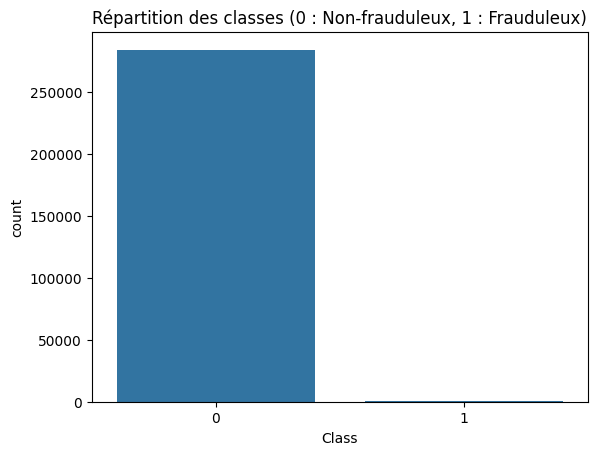

In [7]:
# Vérification des valeurs manquantes
print(data.isnull().sum())

# Distribution des classes (frauduleux vs non frauduleux)
sns.countplot(x='Class', data=data)
plt.title('Répartition des classes (0 : Non-frauduleux, 1 : Frauduleux)')
plt.show()

## Préparation des Données

In [8]:
# Séparation des caractéristiques et de la cible
X = data.drop('Class', axis=1)
y = data['Class']

# Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Utilisation de SMOTE pour gérer le déséquilibre des classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## Construction du Modèle

In [9]:
# Création et entraînement du modèle Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Évaluation du Modèle

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



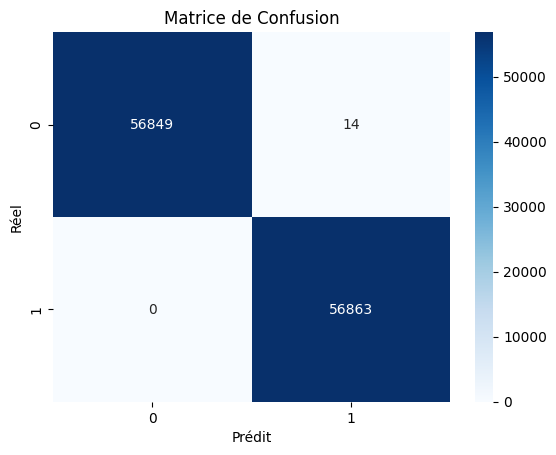

In [10]:
# Prédictions et rapport de classification
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilités pour la courbe ROC

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Réel')
plt.xlabel('Prédit')
plt.show()

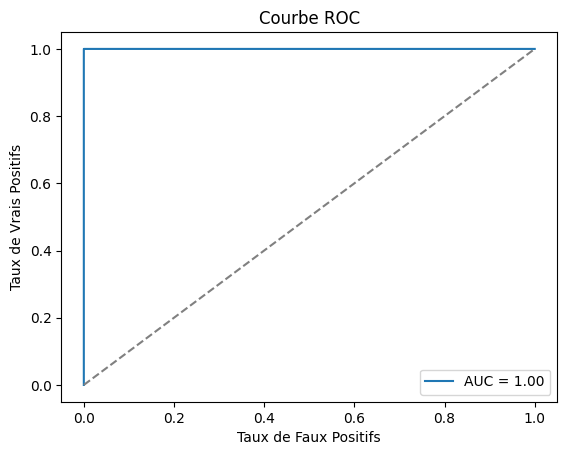

In [11]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Courbe ROC')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.legend()
plt.show()

## Optimisation des Hyperparamètres

In [12]:
# Optimisation avec RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,  # Limité à 10 combinaisons aléatoires
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,  # Parallélisation
    random_state=42
)

# Entraînement du modèle avec RandomizedSearchCV
random_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
print('Meilleurs paramètres:', random_search.best_params_)

# Évaluation du meilleur modèle
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

Meilleurs paramètres: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

